In [21]:
import datetime
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from njit_funcs_recursive_grid import *
from backtest import backtest
from plotting import plot_fills
from downloader import Downloader, load_hlc_cache
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    create_xk,
    round_dynamic,
    round_values,
    sort_dict_keys,
)
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

In [23]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [24]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/default.hjson"
        self.exchange = "binance"
        self.symbol = "FTMUSDT"
        self.market_type = "futures"
        self.user = "binance_01"
        self.start_date = "2022-02-01"
        self.end_date = "2022-02-18"
        self.starting_balance = 10000.0
        self.starting_configs = ""
        self.base_dir = "backtests"
        self.ohlcv = True  # set to False to use 1s candles


config = await prepare_backtest_config(Args())
dl = Downloader(config)
sts = time()
if config["ohlcv"]:
    data = load_hlc_cache(
        config["symbol"],
        config["start_date"],
        config["end_date"],
        base_dir=config["base_dir"],
        spot=config["spot"],
    )
    prices = data[:, 3]
    highs = data[:, 1]
    lows = data[:, 2]
    closes = data[:, 3]
else:
    downloader = Downloader(config)
    data = await downloader.get_sampled_ticks()
    prices = data[:, 2]
    highs = data[:, 2]
    lows = data[:, 2]
    closes = data[:, 2]
timestamps = data[:, 0]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings...
linear perpetual
linear perpetual
2022-02-22T14:02:24  Validating file 240600000_240699999_1644867097676_1644892827934.csv 2022-02-15T02:31:37.676000 
2022-02-22T14:02:24  Saving file 240600000_240699999_1644867097676_1644892827934_verified.csv 2022-02-15T02:31:37.676000 
2022-02-22T14:02:24  Removed file 240600000_240699999_1644867097676_1644892827934.csv 
2022-02-22T14:02:24  Validating file 240700000_240799999_1644892828862_1644922573323.csv 2022-02-15T09:40:28.862000 
2022-02-22T14:02:25  Saving file 240700000_240799999_1644892828862_1644922573323_verified.csv 2022-02-15T09:40:28.862000 
2022-02-22T14:02:25  Removed file 240700000_240799999_1644892828862_1644922573323.csv 
2022-02-22T14:02:25  Validating file 240800000_240899999_1644922573323_1644947088757.csv 2022-02-15T17:56:13.323000 
2022-02-22T14:02:25  Saving file 240800000_240899999_1644922573323_1644947088757_verified.csv 2022-02-15T17:56:13.323000 
2022-02-22T14:02:25  Removed file 2408

C:\AgodaGit\passivbot\downloader.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gaps = gaps.append(


2022-02-22T14:02:28  fetched ticks FTMUSDT 241637810 2022-02-18T07:05:30.469000 
2022-02-22T14:02:29  fetched ticks FTMUSDT 241638809 2022-02-18T07:09:20.502000 
2022-02-22T14:02:30  fetched ticks FTMUSDT 241639808 2022-02-18T07:13:25.452000 
2022-02-22T14:02:31  fetched ticks FTMUSDT 241640807 2022-02-18T07:16:12.933000 
2022-02-22T14:02:31  fetched ticks FTMUSDT 241641806 2022-02-18T07:19:54.857000 
2022-02-22T14:02:32  fetched ticks FTMUSDT 241642805 2022-02-18T07:27:30.016000 
2022-02-22T14:02:33  fetched ticks FTMUSDT 241643804 2022-02-18T07:33:53.706000 
2022-02-22T14:02:34  fetched ticks FTMUSDT 241644803 2022-02-18T07:40:09.803000 
2022-02-22T14:02:34  fetched ticks FTMUSDT 241645802 2022-02-18T07:47:14.953000 
2022-02-22T14:02:35  fetched ticks FTMUSDT 241646801 2022-02-18T07:53:05.214000 
2022-02-22T14:02:36  fetched ticks FTMUSDT 241647800 2022-02-18T07:58:30.596000 
2022-02-22T14:02:37  fetched ticks FTMUSDT 241648799 2022-02-18T08:03:52.607000 
2022-02-22T14:02:38  fetched

<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

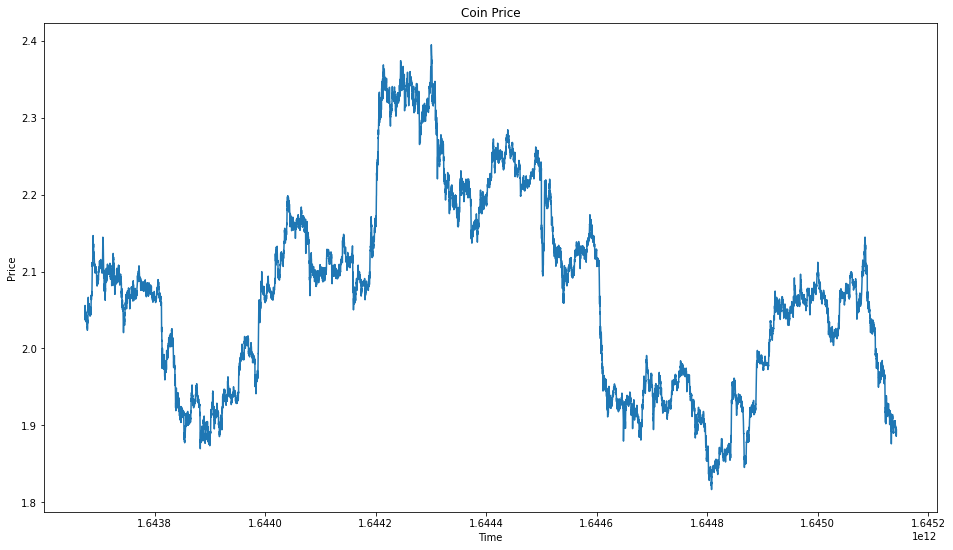

In [25]:
df = pd.DataFrame({"timestamp": timestamps, "price": prices}).set_index("timestamp")
df.price.iloc[::100].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [26]:
# choose a slice on which to test
wsize_days = 365
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]
len(dataslice)

In [27]:
hand_tuned = {
    "long": {
        "enabled": True,
        "ema_span_0": 1036.4758617491368,
        "ema_span_1": 1125.5167077975314,
        "initial_qty_pct": 0.01,
        "initial_eprice_ema_dist": -0.02,
        "wallet_exposure_limit": 1.0,
        "ddown_factor": 0.6,
        "rentry_pprice_dist": 0.015,
        "rentry_pprice_dist_wallet_exposure_weighting": 15,
        "min_markup": 0.02,
        "markup_range": 0.02,
        "n_close_orders": 7,
        "auto_unstuck_wallet_exposure_threshold": 0.15,
        "auto_unstuck_ema_dist": 0.02,
    },
    "short": {
        "enabled": True,
        "ema_span_0": 5790.833763793811,
        "ema_span_1": 5782.050959052051,
        "initial_qty_pct": 0.029,
        "initial_eprice_ema_dist": 0.051,
        "wallet_exposure_limit": 1.0,
        "ddown_factor": 0.62,
        "rentry_pprice_dist": 0.016,
        "rentry_pprice_dist_wallet_exposure_weighting": 17,
        "min_markup": 0.026,
        "markup_range": 0.021,
        "n_close_orders": 8,
        "auto_unstuck_wallet_exposure_threshold": 0.193,
        "auto_unstuck_ema_dist": 0.003,
    },
}
config_to_test = {**config, **hand_tuned}

In [28]:
import datetime


#config_to_test['long']['initial_eprice_ema_dist'] = 0.0005

grid_long = calc_recursive_entries_long(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test["inverse"],
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["long"]["initial_qty_pct"],
    config_to_test["long"]["initial_eprice_ema_dist"],
    config_to_test["long"]["ddown_factor"],
    config_to_test["long"]["rentry_pprice_dist"],
    config_to_test["long"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["long"]["wallet_exposure_limit"],
    config_to_test["long"]["auto_unstuck_ema_dist"],
    config_to_test["long"]["auto_unstuck_wallet_exposure_threshold"],
    whole_grid=True,
)

grid_short = calc_recursive_entries_short(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test["inverse"],
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["short"]["initial_qty_pct"],
    config_to_test["short"]["initial_eprice_ema_dist"],
    config_to_test["short"]["ddown_factor"],
    config_to_test["short"]["rentry_pprice_dist"],
    config_to_test["short"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["short"]["wallet_exposure_limit"],
    config_to_test["short"]["auto_unstuck_ema_dist"],
    config_to_test["short"]["auto_unstuck_wallet_exposure_threshold"],
    whole_grid=True,
)

gdf_long = pd.DataFrame(
    grid_long, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_long.loc[:, "eprice_pprice_diff"] = abs(gdf_long.price - gdf_long.pprice) / gdf_long.price
gdf_long.loc[:, "ddown_factor"] = gdf_long.qty / gdf_long.psize.shift()
gdf_long.loc[:, "bkr_price"] = gdf_long.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)
gdf_short = pd.DataFrame(
    grid_short, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_short.loc[:, "eprice_pprice_diff"] = abs(gdf_short.price - gdf_short.pprice) / gdf_short.price
gdf_short.loc[:, "ddown_factor"] = gdf_short.qty / gdf_short.psize.shift()
gdf_short.loc[:, "bkr_price"] = gdf_short.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)

# Display grid on graph
from_date = datetime.datetime(year=2022,month=1,day=1).timestamp()*1000
to_date = datetime.datetime(year=2022,month=2,day=18).timestamp()*1000

from_tick = np.where(timestamps == from_date)[0][0]
to_tick = np.where(timestamps == to_date)[0][0]
# n_ticks = to_date - from_date

#n_ticks = 60 * 60 * 24 * 45  # 14 days

dfx = pd.DataFrame(
    {
        "timestamp": pd.to_datetime(timestamps[-n_ticks:], unit="ms"),
        "qty": qtys[-n_ticks:],
        "price": prices[-n_ticks:],
    }
).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
fig = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=180) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
if config_to_test["long"]["enabled"]:
    for i, e in enumerate(gdf_long.itertuples()):
        fig.axhline(y=e.price, color="g", linestyle="-")
    print(f"\nGrid Span Long = {-(gdf_long.price.iloc[-1] / gdf_long.price.iloc[0] - 1) * 100:.2f}%")

if config_to_test["short"]["enabled"]:
    for i, e in enumerate(gdf_short.itertuples()):
        fig.axhline(y=e.price, color="r", linestyle="-")
    print(f"Grid Span Short = {(gdf_short.price.iloc[-1] / gdf_short.price.iloc[0] - 1) * 100:.2f}%")

pd.concat([gdf_long, gdf_short]).sort_values("price", ascending=False)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
sts = time()
fills_long, fills_short, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test)
pprint.pprint(analysis)

In [ ]:
sdf

In [ ]:
sdf.balance_long.plot()
sdf.equity_long.plot(title="Balance and equity long", xlabel="Time", ylabel="Balance")

In [ ]:
sdf.balance_short.plot()
sdf.equity_short.plot(title="Balance and equity short", xlabel="Time", ylabel="Balance")

In [ ]:
if len(longs) > 0:
    plot_fills(df, longs, plot_whole_df=True, title="Overview Fills Long")

In [ ]:
if len(shorts) > 0:
    plot_fills(df, shorts, plot_whole_df=True, title="Overview Fills Short")

In [ ]:
sdf[["psize_long", "psize_short"]].plot(
    title="Position size in terms of contracts", xlabel="Time", ylabel="Long Position size"
)

In [ ]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf[sdf.psize_long != 0].pprice_long.replace(0.0, np.nan).plot()
sdf[sdf.psize_short != 0].pprice_short.replace(0.0, np.nan).plot()

In [ ]:
lpprices = sdf[sdf.psize_long != 0.0]
PADistance_long = (lpprices.pprice_long - lpprices.price).abs() / lpprices.price
print(f"Price action distance long mean {PADistance_long.mean():.6f} std {PADistance_long.std():.6f}")
PADistance_long.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

In [ ]:
spprices = sdf[sdf.psize_short != 0.0]
PADistance_short = (spprices.pprice_short - spprices.price).abs() / spprices.price
print(f"Mean price action distance short {PADistance_short.mean():.6f}")
PADistance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

In [ ]:
# Inspect long EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["long"]["ema_span_0"],
    (config_to_test["long"]["ema_span_0"] * config_to_test["long"]["ema_span_1"]) ** 0.5,
    config_to_test["long"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)

spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["long"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["long"]["auto_unstuck_ema_dist"])
long_ientry_band = ema_band_lower * (1 - config_to_test["long"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(
    style="b--",
)
unstucking_band_upper.iloc[::100].plot(style="r--")
long_ientry_band.iloc[::100].plot(style="g-.")

In [ ]:
# Inspect short EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["short"]["ema_span_0"],
    (config_to_test["short"]["ema_span_0"] * config_to_test["short"]["ema_span_1"]) ** 0.5,
    config_to_test["short"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)

spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["short"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["short"]["auto_unstuck_ema_dist"])
short_ientry_band = ema_band_upper * (1 + config_to_test["short"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(style="b--")
unstucking_band_upper.iloc[::100].plot(style="r--")
short_ientry_band.iloc[::100].plot(style="g-.")